<a href="https://colab.research.google.com/github/zdvinkofff/Developer-AI/blob/main/RFM_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

КЛАСТЕРИЗАЦИЯ

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
tx_data = pd.read_csv('/content/OnlineRetail.csv',encoding='unicode_escape')
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


Recency

<ipython-input-10-765747fb26e2>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tx_data['InvoiceDate'].describe()


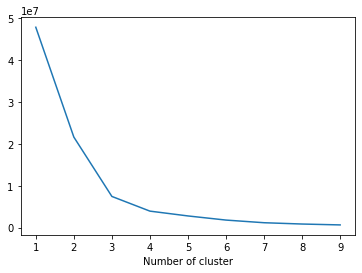

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,772.0,53.099741,40.329855,0.0,30.0,61.0,91.0,125.0
1,493.0,321.693712,39.234928,275.0,290.0,314.0,348.0,449.0
2,1125.0,213.840889,31.783724,154.0,193.0,214.0,244.0,267.0
3,123.0,600.089431,80.321078,480.0,511.0,633.0,661.0,692.0


In [ ]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_data['InvoiceDate'].describe()
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])
tx_user.groupby('RecencyCluster')['Recency'].describe()

In [ ]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final




tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
tx_user

,CustomerID,Recency,RecencyCluster
0,17850.0,64,3
1,15100.0,65,3
2,15291.0,4,3
3,14688.0,61,3
4,17809.0,33,3
...,...,...,...
2508,15124.0,333,1
2509,16969.0,333,1
2510,14597.0,333,1
2511,13917.0,333,1


Frequency

In [ ]:
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,55
2,12748.0,1378
3,12749.0,54
4,12820.0,11


In [ ]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,64,3,312
1,15100.0,65,3,6
2,15291.0,4,3,62
3,14688.0,61,3,183
4,17809.0,33,3,20


<ipython-input-25-a1c8fb6b3bda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_frequency["clusters"] = kmeans.labels_
<ipython-input-25-a1c8fb6b3bda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_frequency["clusters"] = kmeans.labels_
<ipython-input-25-a1c8fb6b3bda>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

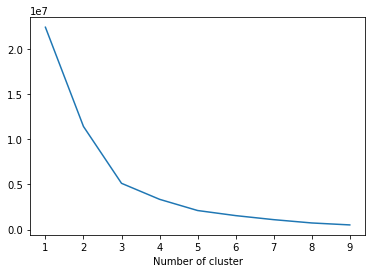

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2173.0,29.655315,23.760689,1.0,11.0,22.0,44.00,96.0
1,315.0,163.958730,56.713114,97.0,115.0,148.0,197.50,342.0
2,4.0,1544.250000,393.334781,1240.0,1343.5,1408.0,1608.75,2121.0
3,21.0,544.666667,180.823763,364.0,407.0,462.0,617.00,911.0


In [ ]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


In [ ]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

Monetary Value

In [ ]:
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']

In [ ]:
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [ ]:
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,2091.40
2,12748.0,9322.82
3,12749.0,782.10
4,12820.0,170.46


In [ ]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [ ]:
tx_user.Revenue.describe()

count     2513.000000
mean      1015.785500
std       2738.298548
min      -1192.200000
25%        218.050000
50%        427.740000
75%        959.440000
max      64483.900000
Name: Revenue, dtype: float64

<ipython-input-43-7750bac40a86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_revenue["clusters"] = kmeans.labels_
<ipython-input-43-7750bac40a86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_revenue["clusters"] = kmeans.labels_
<ipython-input-43-7750bac40a86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

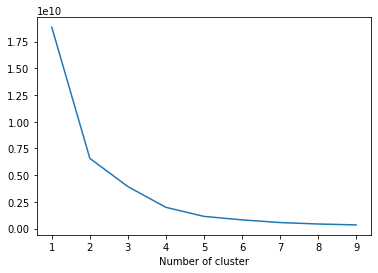

In [ ]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [ ]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [ ]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2347.0,589.818837,549.491206,-1192.20,207.5000,388.330,809.815,2719.20
1,152.0,4874.410138,2518.198130,2735.75,3186.6025,3833.925,5712.550,14375.95
2,12.0,25697.289167,4963.052730,17637.74,21584.1175,26509.760,28177.195,35476.42
3,2.0,59543.170000,6987.247374,54602.44,57072.8050,59543.170,62013.535,64483.90
